# 4. Modeling and Evaluation

4 different models are fitted with different training data to evalute data impact (class imbalance, number of samples) on modeling.
* using training data without augmentation (classes are imbalanced; varying from varying from 122 to 4406)
* using augementated training data (classes are imbalanced; varying from 915 to 4406)
* using Bootstrapping to draw 200 images from each class in the training data without augmentation for 5 times (classes are balanced)
* using Bootstrapping to draw 900 images from each class in the augmented training data for 5 times (classes are balanced)

Model performance is evaluted using the same testing data (unseen to models).


In [1]:
# Import dependencies
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imghdr
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras.metrics import AUC, SparseCategoricalAccuracy

from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## 4.1. Load Testing Data
Testing data were splitted out from the origianl input in the feature engineering step.

Going to be used for evaluating performance of different models in this notebook.

In [2]:
# Load test data 
test_dir = '..\\data\\Plant_leave_diseases_dataset_without_augmentation_test_data'
print(f'Total number of classes is {len(os.listdir(test_dir))}.')

# Use batch to load in the images 
batch_size = 64
image_size = (128, 128)  # images are resized while reading
test_data = tf.keras.utils.image_dataset_from_directory(test_dir, batch_size = batch_size, image_size = image_size)
print(f'There are {len(test_data)} batches in the testing data.')

Total number of classes is 39.
Found 11077 files belonging to 39 classes.
There are 174 batches in the testing data.


In [3]:
# rescale the test data as required in the preprocessing step
test_data = test_data.map(lambda x, y: (x / 255, y))

## 4.2. Modeling with Training Data Set 1

Class are unbalanced in training data set 1 (no augmentation; number of images varies from 122 to 4406)

### 4.2.1 Load Training Data

In [4]:
# Define the training data directory
data_dir = '..\\data\\Plant_leave_diseases_dataset_without_augmentation_train_data'
print(f'Total number of classes is {len(os.listdir(data_dir))}.')

# Use batch to load in the images 
batch_size = 64
image_size = (128, 128)  # images are resized while reading
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size = batch_size, image_size = image_size)

Total number of classes is 39.
Found 44371 files belonging to 39 classes.


In [5]:
# Apply the scaling in the preprocessing
data = data.map(lambda x, y : (x / 255, y))

In [6]:
# Check how many batches in total
len(data)

694

In [7]:
# Split the training data into training and validation
train_size = int(0.7*len(data))
val_size = int(0.3*len(data))

train = data.take(train_size)
val = data.skip(train_size).take(val_size)

len(train), len(val)

(485, 208)

### 4.2.2. Modeling

In [36]:
# Create the CNN model
model1 = Sequential()

# Add layers to the model
model1.add(Conv2D(32, (3,3), 1, activation = 'relu', input_shape = (128,128,3)))
model1.add(MaxPooling2D())

model1.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model1.add(MaxPooling2D())

model1.add(Conv2D(8, (3,3), 1, activation = 'relu'))
model1.add(MaxPooling2D())

model1.add(Flatten())

model1.add(Dense(128, activation = 'relu'))

model1.add(Dropout(0.2))

model1.add(Dense(39, activation = 'softmax'))

In [37]:
# Compile the model
model1.compile('adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [38]:
# Check model summary
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 16)        4624      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 8)         1160      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 8)        

In [39]:
# Create call back
logdir = '..\\log'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [40]:
# Train the model
hist = model1.fit(train, epochs = 15, validation_data = val, )

Epoch 1/15
485/485 [==============================] - 364s 724ms/step - loss: 2.0168 - accuracy: 0.4484 - val_loss: 1.0874 - val_accuracy: 0.6835
Epoch 2/15
485/485 [==============================] - 204s 421ms/step - loss: 1.0696 - accuracy: 0.6752 - val_loss: 0.7688 - val_accuracy: 0.7664
Epoch 3/15
485/485 [==============================] - 241s 496ms/step - loss: 0.8267 - accuracy: 0.7445 - val_loss: 0.6472 - val_accuracy: 0.8031
Epoch 4/15
485/485 [==============================] - 247s 507ms/step - loss: 0.7018 - accuracy: 0.7812 - val_loss: 0.6249 - val_accuracy: 0.8041
Epoch 5/15
485/485 [==============================] - 245s 505ms/step - loss: 0.6202 - accuracy: 0.8025 - val_loss: 0.6069 - val_accuracy: 0.8066
Epoch 6/15
485/485 [==============================] - 245s 505ms/step - loss: 0.5789 - accuracy: 0.8137 - val_loss: 0.5827 - val_accuracy: 0.8178
Epoch 7/15
485/485 [==============================] - 243s 501ms/step - loss: 0.5154 - accuracy: 0.8361 - val_loss: 0.4472 -

In [46]:
# Print out the training history
hist.history

{'loss': [2.01680326461792,
  1.0695909261703491,
  0.8266900181770325,
  0.7017605900764465,
  0.6202480792999268,
  0.5789210200309753,
  0.5154489278793335,
  0.48527199029922485,
  0.4605761766433716,
  0.43132418394088745,
  0.4123830497264862,
  0.3900161683559418,
  0.3779990077018738,
  0.3516843616962433,
  0.3350096046924591],
 'accuracy': [0.4484213888645172,
  0.6751933097839355,
  0.7445231676101685,
  0.7811855673789978,
  0.8025451302528381,
  0.813692033290863,
  0.836146891117096,
  0.8451675176620483,
  0.8514175415039062,
  0.8605992197990417,
  0.8652384281158447,
  0.8711662292480469,
  0.8753865957260132,
  0.8835051655769348,
  0.8900451064109802],
 'val_loss': [1.0873783826828003,
  0.7688176035881042,
  0.6471561193466187,
  0.6248776912689209,
  0.6068702936172485,
  0.5827217698097229,
  0.44721725583076477,
  0.4868108630180359,
  0.4504099488258362,
  0.42908528447151184,
  0.43581369519233704,
  0.4895677864551544,
  0.4387357831001282,
  0.419788241386413

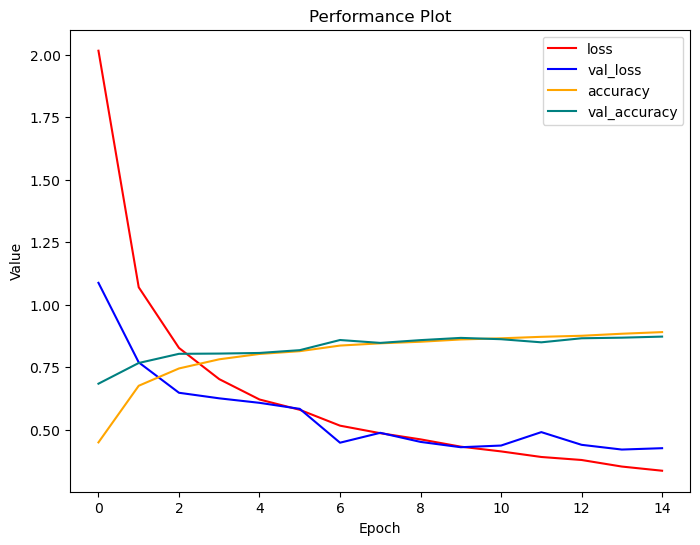

In [56]:
# plot perfromance
plt.figure(figsize = (8,6))

plt.plot(hist.history['loss'], color = 'red', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'blue', label = 'val_loss')
plt.plot(hist.history['accuracy'], color = 'orange', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'teal', label = 'val_accuracy')
plt.title('Performance Plot')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc = 'upper right')
plt.show()

In [42]:
val_loss, val_acc = model1.evaluate(val)
val_acc

208/208 [==============================] - 29s 94ms/step - loss: 0.4245 - accuracy: 0.8724


0.8723707795143127

In [44]:
val_loss, val_acc = model1.evaluate(test_data)
val_acc

174/174 [==============================] - 97s 528ms/step - loss: 0.4270 - accuracy: 0.8707


0.8707231283187866

### 4.2.3. Save the Model

In [99]:
# save out model1
model1.save(os.path.join('..\\models', 'prelim_model1.keras'))

In [10]:
model1_load = load_model(os.path.join('..\\models', 'prelim_model1.keras'))

In [11]:
val_loss, val_acc = model1_load.evaluate(test_data)
val_acc

174/174 [==============================] - 107s 524ms/step - loss: 0.4270 - accuracy: 0.8707


0.8707231283187866

## 4.3. Modeling with Training Data 2 
Class are unbalanced in training data set 2 (with augmentation; number of images varies from 915 to 4406)

### 4.3.1. Load Training Data

In [26]:
# Define the training data directory
data_dir = '..\\data\\Plant_leave_diseases_dataset_with_augmentation_train_data'
print(f'Total number of classes is {len(os.listdir(data_dir))}.')

# Use batch to load in the images 
batch_size = 64
image_size = (128, 128)  # images are resized while reading
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size = batch_size, image_size = image_size)

# Apply the scaling in the preprocessing
data = data.map(lambda x, y : (x / 255, y))
print(f'Input training data length is {len(data)}.')

# Split the training data into training and validation
train_size = int(0.7*len(data))
val_size = int(0.3*len(data))

train = data.take(train_size)
val = data.skip(train_size).take(val_size)

print(f'Training data length is {len(train)}, validation data length is {len(val)}.')

Total number of classes is 39.
Found 53553 files belonging to 39 classes.
Input training data length is 837.
Training data length is 585, validation data length is 251.


### 4.3.2. Modeling

In [27]:
# Create the CNN model
model = Sequential()

# Add layers to the model
model.add(Conv2D(32, (3,3), 1, activation = 'relu', input_shape = (128,128,3)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(8, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))

model.add(Dropout(0.2))

model.add(Dense(39, activation = 'softmax'))

# Compile the model
model.compile('adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Check model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 8)         1160      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 8)         0

Epoch 1/15
585/585 [==============================] - 448s 755ms/step - loss: 2.1812 - accuracy: 0.4007 - val_loss: 1.3423 - val_accuracy: 0.6066
Epoch 2/15
585/585 [==============================] - 242s 413ms/step - loss: 1.3252 - accuracy: 0.6100 - val_loss: 1.0301 - val_accuracy: 0.6948
Epoch 3/15
585/585 [==============================] - 240s 409ms/step - loss: 1.0896 - accuracy: 0.6751 - val_loss: 0.8726 - val_accuracy: 0.7349
Epoch 4/15
585/585 [==============================] - 282s 481ms/step - loss: 0.9475 - accuracy: 0.7124 - val_loss: 0.7606 - val_accuracy: 0.7727
Epoch 5/15
585/585 [==============================] - 283s 484ms/step - loss: 0.8601 - accuracy: 0.7379 - val_loss: 0.7311 - val_accuracy: 0.7759
Epoch 6/15
585/585 [==============================] - 282s 481ms/step - loss: 0.7790 - accuracy: 0.7608 - val_loss: 0.7146 - val_accuracy: 0.7832
Epoch 7/15
585/585 [==============================] - 283s 483ms/step - loss: 0.7336 - accuracy: 0.7706 - val_loss: 0.8833 -

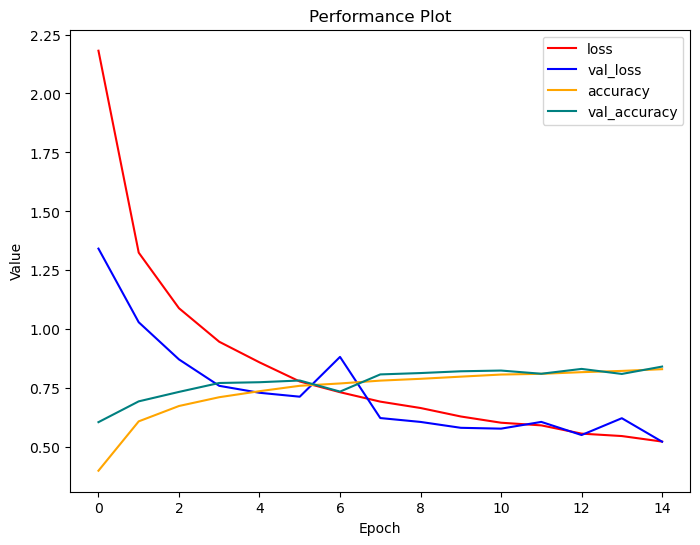

In [28]:
# Train the model
hist = model.fit(train, epochs = 15, validation_data = val)

# plot perfromance
plt.figure(figsize = (8,6))

plt.plot(hist.history['loss'], color = 'red', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'blue', label = 'val_loss')
plt.plot(hist.history['accuracy'], color = 'orange', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'teal', label = 'val_accuracy')
plt.title('Performance Plot')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc = 'upper right')
plt.show()

In [29]:
# check the accuracy on testing data
test_loss, test_acc = model.evaluate(test_data)
test_acc

174/174 [==============================] - 16s 89ms/step - loss: 0.4535 - accuracy: 0.8580


0.857994019985199

### 4.3.3. Save the Model

In [30]:
# save out model
model.save(os.path.join('..\\models', 'prelim_model2.keras'))

# load in the model
model2_load = load_model(os.path.join('..\\models', 'prelim_model2.keras'))

test_loss, test_acc = model2_load.evaluate(test_data)
test_acc

174/174 [==============================] - 16s 89ms/step - loss: 0.4535 - accuracy: 0.8580


0.857994019985199

## 4.4. Modeling with Training Data 3
Bootstrapping to draw 200 images from each class in the training data without augmentation for 5 times (classes are balanced)

### 4.4.1. Load Training Data, Modeling and Save the Models

In [35]:
# loop over 5 bootstrapping training data to train 5 models

for i in range(1, 6):
    
    print(f"Start of {i} sampling ----------------------------------")

    # Define the training data directory
    data_dir = '..\\data\\Plant_leave_diseases_dataset_without_augmentation_train_data_bs_' + str(i)
    print(f'Total number of classes is {len(os.listdir(data_dir))}.')

    # Use batch to load in the images 
    batch_size = 64
    image_size = (128, 128)  # images are resized while reading
    data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size = batch_size, image_size = image_size)

    # Apply the scaling in the preprocessing
    data = data.map(lambda x, y : (x / 255, y))
    print(f'Input training data length is {len(data)}.')

    # Split the training data into training and validation
    train_size = int(0.7*len(data)) 
    val_size = int(0.3*len(data))

    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)

    print(f'Training data length is {len(train)}, validation data length is {len(val)}.')

    # Create the CNN model
    model = Sequential()

    # Add layers to the model
    model.add(Conv2D(32, (3,3), 1, activation = 'relu', input_shape = (128,128,3)))
    model.add(MaxPooling2D())

    model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(8, (3,3), 1, activation = 'relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())

    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.2))

    model.add(Dense(39, activation = 'softmax'))

    # Compile the model
    model.compile('adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    # Fit the model
    hist = model.fit(train, epochs = 15, validation_data = val)

    # test score
    test_loss, test_acc = model.evaluate(test_data)
    print(f'The accuracy on test data is {test_acc}.')
    
    # save out model
    model_name = f'prelim_model3_bs{i}.keras'
    model.save(os.path.join('..\\models', model_name))

Start of 1 sampling ----------------------------------
Total number of classes is 39.
Found 7800 files belonging to 39 classes.
Input training data length is 122.
Training data length is 85, validation data length is 36.
Epoch 1/15
85/85 [==============================] - 76s 842ms/step - loss: 3.5172 - accuracy: 0.0739 - val_loss: 2.9081 - val_accuracy: 0.2240
Epoch 2/15
85/85 [==============================] - 36s 421ms/step - loss: 2.5273 - accuracy: 0.2965 - val_loss: 1.9264 - val_accuracy: 0.4714
Epoch 3/15
85/85 [==============================] - 35s 412ms/step - loss: 1.8370 - accuracy: 0.4623 - val_loss: 1.5942 - val_accuracy: 0.5434
Epoch 4/15
85/85 [==============================] - 35s 412ms/step - loss: 1.4647 - accuracy: 0.5642 - val_loss: 1.3610 - val_accuracy: 0.5885
Epoch 5/15
85/85 [==============================] - 35s 409ms/step - loss: 1.2447 - accuracy: 0.6237 - val_loss: 1.2099 - val_accuracy: 0.6476
Epoch 6/15
85/85 [==============================] - 35s 410ms/st

### 4.4.2. Modle Ensembling

In [125]:
# define a function to count occurence of each unique value in a numpy array
def value_counts_np(arr):
    values, counts = np.unique(arr, return_counts = True)
    index = np.argmax(counts)
    return values[index]

In [126]:
# define a function to combine predictions from different models by majority vote
# This function output predicted labels

def bs_model_majority(X, model_name):
    y_pred_mv = []

    for i in range (1, 6):
        model = load_model(os.path.join('..\\models', f'{model_name}{i}.keras'))
        y_pred_prob = model.predict(X, verbose = 0)
        y_pred = np.argmax(y_pred_prob, axis = 1)
        y_pred_mv.append(y_pred)

    y_pred_mv = np.array(y_pred_mv).T
    y_pred_mv = np.apply_along_axis(value_counts_np, 1, y_pred_mv)
    return y_pred_mv

In [127]:
# define a function to combine predictions from different models by majority vote
# This function output predicted prabobilities for each label

def bs_model_majority_prob(X, model_name):
    y_pred_mv = []

    for i in range (1, 6):
        model = load_model(os.path.join('..\\models', f'{model_name}{i}.keras'))
        y_pred_prob = model.predict(X, verbose = 0)
        y_pred_mv.append(y_pred_prob)

    y_pred_mv = np.array(y_pred_mv)
    y_pred_mv = np.apply_along_axis(value_counts_np, 0, y_pred_mv)
    
    return y_pred_mv

In [131]:
# define a metric calculation function

def metric_cal(model_name, metric_name, combined = True):
    for X, y in test_data:
        # make predictions
        if combined:
            y_hat = bs_model_majority_prob(X, model_name)
        else:
            model = load_model(os.path.join('..\\models', str(model_name)))
            y_hat = model.predict(X, verbose = 0)
        # update the metrics
        metric_name.update_state(y, y_hat)
        # return output
    return metric_name.result().numpy()

In [135]:
# calcualte accuracy for test data using combined model 3
model_name = 'prelim_model3_bs'

sparsacc = SparseCategoricalAccuracy()
sparscros = SparseCategoricalCrossentropy()

test_acc_3 = metric_cal(model_name, sparsacc)
test_cros_3 = metric_cal(model_name, sparscros)

print(f'For model 3 (combined from 5 models), accuracy for test data is {test_acc_3}.')
print(f'For model 3 (combined from 5 models), cross entropy for test data is {test_cros_3}.')

For model 3 (combined from 5 models), accuracy for test data is 0.7951611280441284.
For model 3 (combined from 5 models), cross entropy for test data is 0.8529471755027771.


Let's evalute the performance of individual model

In [ ]:
# load in the model
model3_bs1_load = load_model(os.path.join('..\\models', 'prelim_model3_bs1.keras'))

test_loss, test_acc = model3_bs1_load.evaluate(test_data)
test_acc

174/174 [==============================] - 16s 91ms/step - loss: 1.3874 - accuracy: 0.6443


0.6443080306053162

In [ ]:
# load in the model
model3_bs2_load = load_model(os.path.join('..\\models', 'prelim_model3_bs2.keras'))

test_loss, test_acc = model3_bs2_load.evaluate(test_data)
test_acc

174/174 [==============================] - 16s 91ms/step - loss: 1.4688 - accuracy: 0.6648


0.6648009419441223

In [ ]:
# load in the model
model3_bs3_load = load_model(os.path.join('..\\models', 'prelim_model3_bs3.keras'))

test_loss, test_acc = model3_bs3_load.evaluate(test_data)
test_acc

174/174 [==============================] - 16s 91ms/step - loss: 1.0808 - accuracy: 0.7066


0.706599235534668

In [ ]:
# load in the model
model3_bs4_load = load_model(os.path.join('..\\models', 'prelim_model3_bs4.keras'))

test_loss, test_acc = model3_bs4_load.evaluate(test_data)
test_acc

174/174 [==============================] - 16s 90ms/step - loss: 1.0241 - accuracy: 0.7306


0.7306129932403564

In [ ]:
# load in the model
model3_bs5_load = load_model(os.path.join('..\\models', 'prelim_model3_bs5.keras'))

test_loss, test_acc = model3_bs5_load.evaluate(test_data)
test_acc

174/174 [==============================] - 16s 91ms/step - loss: 1.1338 - accuracy: 0.6926


0.6926063299179077

**Note:**
The combined performance is better than those of individual models.

## 4.5. Modeling with Training Data 4
Bootstrapping to draw 900 images from each class in the augmented training data for 5 times (classes are balanced)

### 4.5.1. Load Training Data, Modeling and Save the Models

In [38]:
# loop over 5 bootstrapping training data to train 5 models

for i in range(1, 6):
    
    print(f"Start of {i} sampling ----------------------------------")

    # Define the training data directory
    data_dir = '..\\data\\Plant_leave_diseases_dataset_with_augmentation_train_data_bs_' + str(i)
    print(f'Total number of classes is {len(os.listdir(data_dir))}.')

    # Use batch to load in the images 
    batch_size = 64
    image_size = (128, 128)  # images are resized while reading
    data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size = batch_size, image_size = image_size)

    # Apply the scaling in the preprocessing
    data = data.map(lambda x, y : (x / 255, y))
    print(f'Input training data length is {len(data)}.')

    # Split the training data into training and validation
    train_size = int(0.7*len(data)) 
    val_size = int(0.3*len(data))

    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)

    print(f'Training data length is {len(train)}, validation data length is {len(val)}.')

    # Create the CNN model
    model = Sequential()

    # Add layers to the model
    model.add(Conv2D(32, (3,3), 1, activation = 'relu', input_shape = (128,128,3)))
    model.add(MaxPooling2D())

    model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(8, (3,3), 1, activation = 'relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())

    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.2))

    model.add(Dense(39, activation = 'softmax'))

    # Compile the model
    model.compile('adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    # Fit the model
    hist = model.fit(train, epochs = 15, validation_data = val)

    # test score
    test_loss, test_acc = model.evaluate(test_data)
    print(f'The accuracy on test data is {test_acc}.')
    
    # save out model
    model_name = f'prelim_model4_bs{i}.keras'
    model.save(os.path.join('..\\models', model_name))

Start of 1 sampling ----------------------------------
Total number of classes is 39.
Found 35100 files belonging to 39 classes.
Input training data length is 549.
Training data length is 384, validation data length is 164.
Epoch 1/15
384/384 [==============================] - 283s 724ms/step - loss: 2.4240 - accuracy: 0.3207 - val_loss: 1.5024 - val_accuracy: 0.5671
Epoch 2/15
384/384 [==============================] - 157s 408ms/step - loss: 1.4329 - accuracy: 0.5677 - val_loss: 1.1141 - val_accuracy: 0.6708
Epoch 3/15
384/384 [==============================] - 158s 411ms/step - loss: 1.1773 - accuracy: 0.6425 - val_loss: 1.0458 - val_accuracy: 0.6854
Epoch 4/15
384/384 [==============================] - 188s 489ms/step - loss: 1.0119 - accuracy: 0.6876 - val_loss: 0.8635 - val_accuracy: 0.7433
Epoch 5/15
384/384 [==============================] - 188s 488ms/step - loss: 0.9083 - accuracy: 0.7197 - val_loss: 0.7960 - val_accuracy: 0.7601
Epoch 6/15
384/384 [==========================

### 4.5.2. Modle Ensembling

In [137]:
# calcualte accuracy for test data using combined model 4
model_name = 'prelim_model4_bs'

sparsacc = SparseCategoricalAccuracy()
sparscros = SparseCategoricalCrossentropy()

test_acc_4 = metric_cal(model_name, sparsacc)
test_cros_4 = metric_cal(model_name, sparscros)

print(f'For model 4 (combined from 5 models), accuracy for test data is {test_acc_4}.')
print(f'For model 4 (combined from 5 models), cross entropy for test data is {test_cros_4}.')

For model 4 (combined from 5 models), accuracy for test data is 0.8833619356155396.
For model 4 (combined from 5 models), cross entropy for test data is 0.45961156487464905.


In [ ]:
# load in the model
model4_bs1_load = load_model(os.path.join('..\\models', 'prelim_model4_bs1.keras'))

test_loss, test_acc = model4_bs1_load.evaluate(test_data)
test_acc

174/174 [==============================] - 16s 93ms/step - loss: 0.6694 - accuracy: 0.8095


0.8095152378082275

In [ ]:
# load in the model
model4_bs2_load = load_model(os.path.join('..\\models', 'prelim_model4_bs2.keras'))

test_loss, test_acc = model4_bs2_load.evaluate(test_data)
test_acc

174/174 [==============================] - 16s 91ms/step - loss: 0.6685 - accuracy: 0.8216


0.8216123580932617

In [ ]:
# load in the model
model4_bs3_load = load_model(os.path.join('..\\models', 'prelim_model4_bs3.keras'))

test_loss, test_acc = model4_bs3_load.evaluate(test_data)
test_acc

174/174 [==============================] - 16s 89ms/step - loss: 0.6001 - accuracy: 0.8281


0.8281123042106628

In [47]:
# load in the model
model4_bs4_load = load_model(os.path.join('..\\models', 'prelim_model4_bs4.keras'))

test_loss, test_acc = model4_bs4_load.evaluate(test_data)
test_acc

174/174 [==============================] - 16s 89ms/step - loss: 0.6092 - accuracy: 0.8226


0.8226053714752197

In [48]:
# load in the model
model4_bs5_load = load_model(os.path.join('..\\models', 'prelim_model4_bs5.keras'))

test_loss, test_acc = model4_bs5_load.evaluate(test_data)
test_acc

174/174 [==============================] - 18s 99ms/step - loss: 0.7813 - accuracy: 0.8018


0.801841676235199

**Note:**
The combined performance is better than those of individual models.

## 4.6. Model Evaluation
Load in the saved models and evaluate the following metrics using test data
* Accuracy
* Cross Entropy
* Classification Report
* Confusion Matrix

In [139]:
# calcualte accuracy for test data using model 1
model_name = 'prelim_model1.keras'

sparsacc = SparseCategoricalAccuracy()
sparscros = SparseCategoricalCrossentropy()

test_acc_1 = metric_cal(model_name, sparsacc, combined = False)
test_cros_1 = metric_cal(model_name, sparscros, combined = False)

print(f'For model 1 (combined from 5 models), accuracy for test data is {test_acc_1}.')
print(f'For model 1 (combined from 5 models), cross entropy for test data is {test_cros_1}.')

For model 1 (combined from 5 models), accuracy for test data is 0.8707231283187866.
For model 1 (combined from 5 models), cross entropy for test data is 0.42595213651657104.


In [136]:
# calcualte accuracy for test data using model 2
model_name = 'prelim_model2.keras'

sparsacc = SparseCategoricalAccuracy()
sparscros = SparseCategoricalCrossentropy()

test_acc_2 = metric_cal(model_name, sparsacc, combined = False)
test_cros_2 = metric_cal(model_name, sparscros, combined = False)

print(f'For model 2 (combined from 5 models), accuracy for test data is {test_acc_2}.')
print(f'For model 2 (combined from 5 models), cross entropy for test data is {test_cros_2}.')

For model 2 (combined from 5 models), accuracy for test data is 0.857994019985199.
For model 2 (combined from 5 models), cross entropy for test data is 0.452355295419693.


In [142]:
# create a table for accuracy and cross entropy
import pandas as pd

acc_list = [round(test_acc_1, 3), round(test_acc_2, 3), round(test_acc_3, 3), round(test_acc_4, 3)]
cros_list = [round(test_cros_1, 3), round(test_cros_2, 3), round(test_cros_3, 3), round(test_cros_4, 3)]
models = ['prelim_model_1', 'prelim_model_2', 'prelim_model_3', 'prelim_model_4']

metric_df = pd.DataFrame({'accuracy': acc_list, 'cross_entropy': cros_list}, index = models)

In [143]:
metric_df

,accuracy,cross_entropy
prelim_model_1,0.871,0.426
prelim_model_2,0.858,0.452
prelim_model_3,0.795,0.853
prelim_model_4,0.883,0.460


**Note:**
* From accuracy, model_4 works the best.
* From cross entropy, model_1 works the best.
* Accuracy of model_1 and model_4 is very close.
* Model_3 fitted with least training data performed worst.
* Both accuracy and cross entropy do not distinguish different classes. Next will evaluate classification report for model_1 and model_4.

In [146]:
# calcualte confusion matrix for model 1

y_pred = []
y_test = []

# make predictions batch by batch and store the results
for X, y in test_data:
    y_proba_batch = model1_load.predict(X, verbose = 0)
    y_pred.extend(np.argmax(y_proba_batch, axis = 1))
    y_test.extend(y.numpy())
    
y_hat_1 = np.array(y_pred)
y_true = np.array(y_test)

# ensure the lengths match
assert y_hat_1.shape == y_true.shape, f"Shape mismatch: y_hat {y_hat_1.shape}, y_true {y_true.shape}"

conf_matrix_1 = confusion_matrix(y_true, y_hat_1)
print(conf_matrix)

[[  82    4    0 ...    0    0    1]
 [   1  106    0 ...    0    2    0]
 [   0    0   20 ...   11    0    0]
 ...
 [   0    0    0 ... 1041    1    0]
 [   0    0    0 ...    0   68    0]
 [   0    0    0 ...    0    0  312]]


In [148]:
# calcualte confusion matrix for model 4

y_pred = []
y_test = []

# make predictions batch by batch and store the results
for X, y in test_data:
    y_proba_batch = bs_model_majority_prob(X, 'prelim_model4_bs')
    y_pred.extend(np.argmax(y_proba_batch, axis = 1))
    y_test.extend(y.numpy())
    
y_hat_4 = np.array(y_pred)
y_true = np.array(y_test)

# ensure the lengths match
assert y_hat_4.shape == y_true.shape, f"Shape mismatch: y_hat {y_hat_4.shape}, y_true {y_true.shape}"

conf_matrix_4 = confusion_matrix(y_true, y_hat_4)
print(conf_matrix)

[[  82    4    0 ...    0    0    1]
 [   1  106    0 ...    0    2    0]
 [   0    0   20 ...   11    0    0]
 ...
 [   0    0    0 ... 1041    1    0]
 [   0    0    0 ...    0   68    0]
 [   0    0    0 ...    0    0  312]]


In [147]:
# calculate classification report for model 1
class_report_1 = classification_report(y_true, y_hat_1)
print(class_report_1)

              precision    recall  f1-score   support

           0       0.80      0.65      0.72       126
           1       0.77      0.85      0.81       124
           2       0.74      0.36      0.49        55
           3       0.74      0.88      0.80       329
           4       0.91      0.89      0.90       228
           5       0.92      0.89      0.90       300
           6       0.91      0.79      0.84       210
           7       0.87      0.88      0.87       170
           8       0.58      0.66      0.61       102
           9       0.97      1.00      0.98       238
          10       0.87      0.65      0.75       197
          11       0.97      0.98      0.98       232
          12       0.88      0.84      0.86       236
          13       0.93      0.92      0.93       276
          14       0.93      0.94      0.94       215
          15       0.94      0.80      0.86        84
          16       0.97      0.98      0.98      1101
          17       0.89    

In [149]:
# calculate classification report for model 4
class_report_4 = classification_report(y_true, y_hat_4)
print(class_report_4)

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       126
           1       0.80      0.85      0.83       124
           2       0.71      0.64      0.67        55
           3       0.80      0.79      0.79       329
           4       0.92      0.89      0.90       228
           5       0.90      0.94      0.92       300
           6       0.91      0.95      0.93       210
           7       0.84      0.92      0.88       170
           8       0.67      0.54      0.60       102
           9       0.95      1.00      0.97       238
          10       0.80      0.86      0.83       197
          11       0.97      0.99      0.98       232
          12       0.83      0.92      0.87       236
          13       0.95      0.91      0.93       276
          14       0.95      0.96      0.96       215
          15       0.92      0.92      0.92        84
          16       0.97      0.96      0.97      1101
          17       0.90    

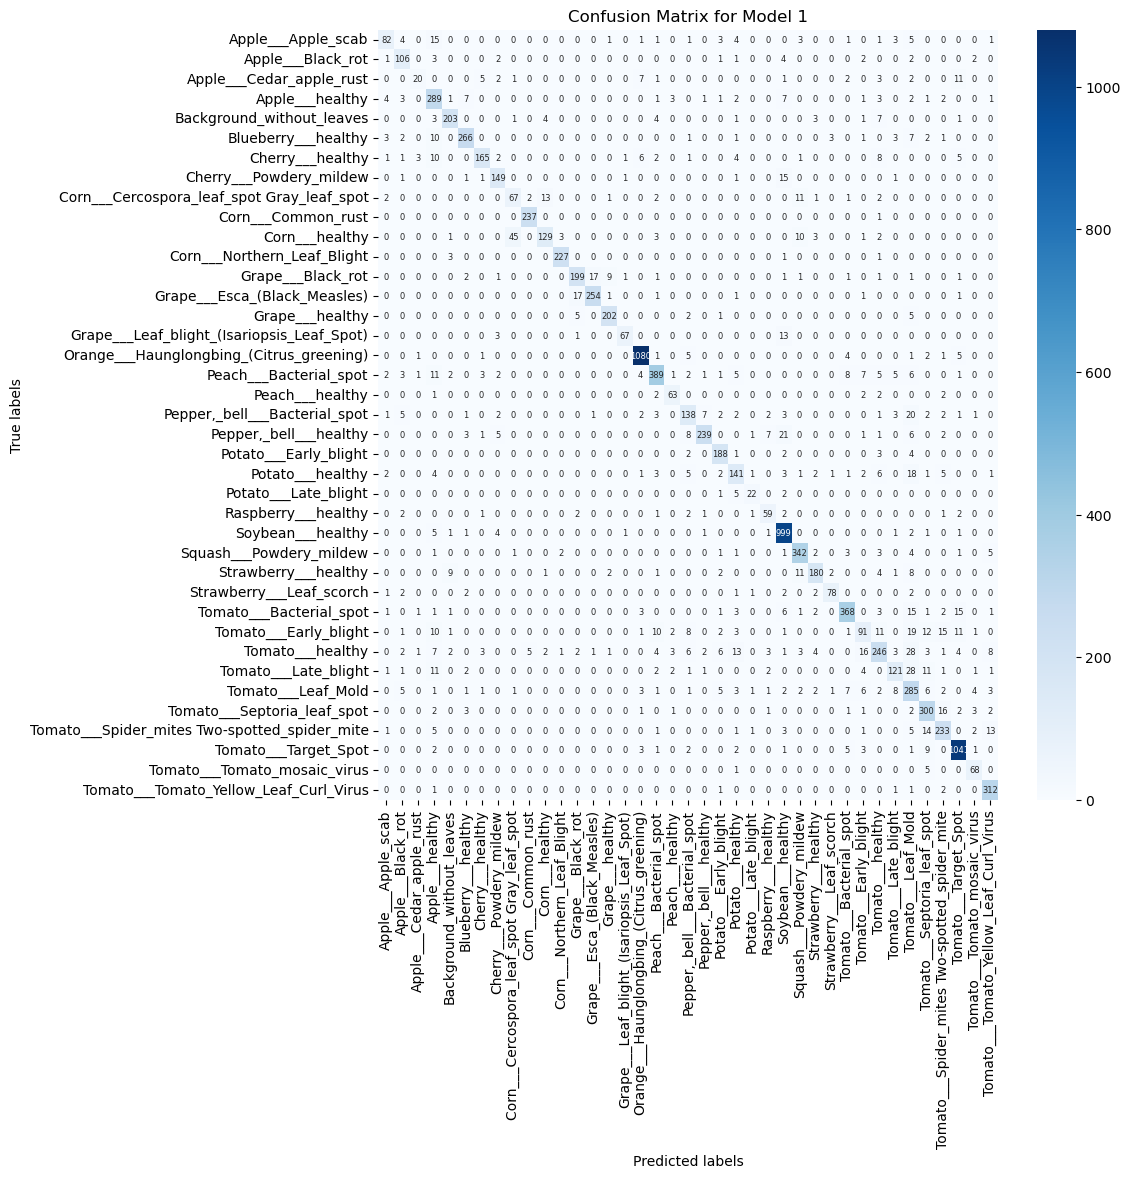

In [150]:
# plot confusion matrix for model 1
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix_1, annot=True, annot_kws={'size': 6}, fmt='g', cmap='Blues', 
            xticklabels=os.listdir(test_dir), 
            yticklabels=os.listdir(test_dir))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Model 1')
plt.show()

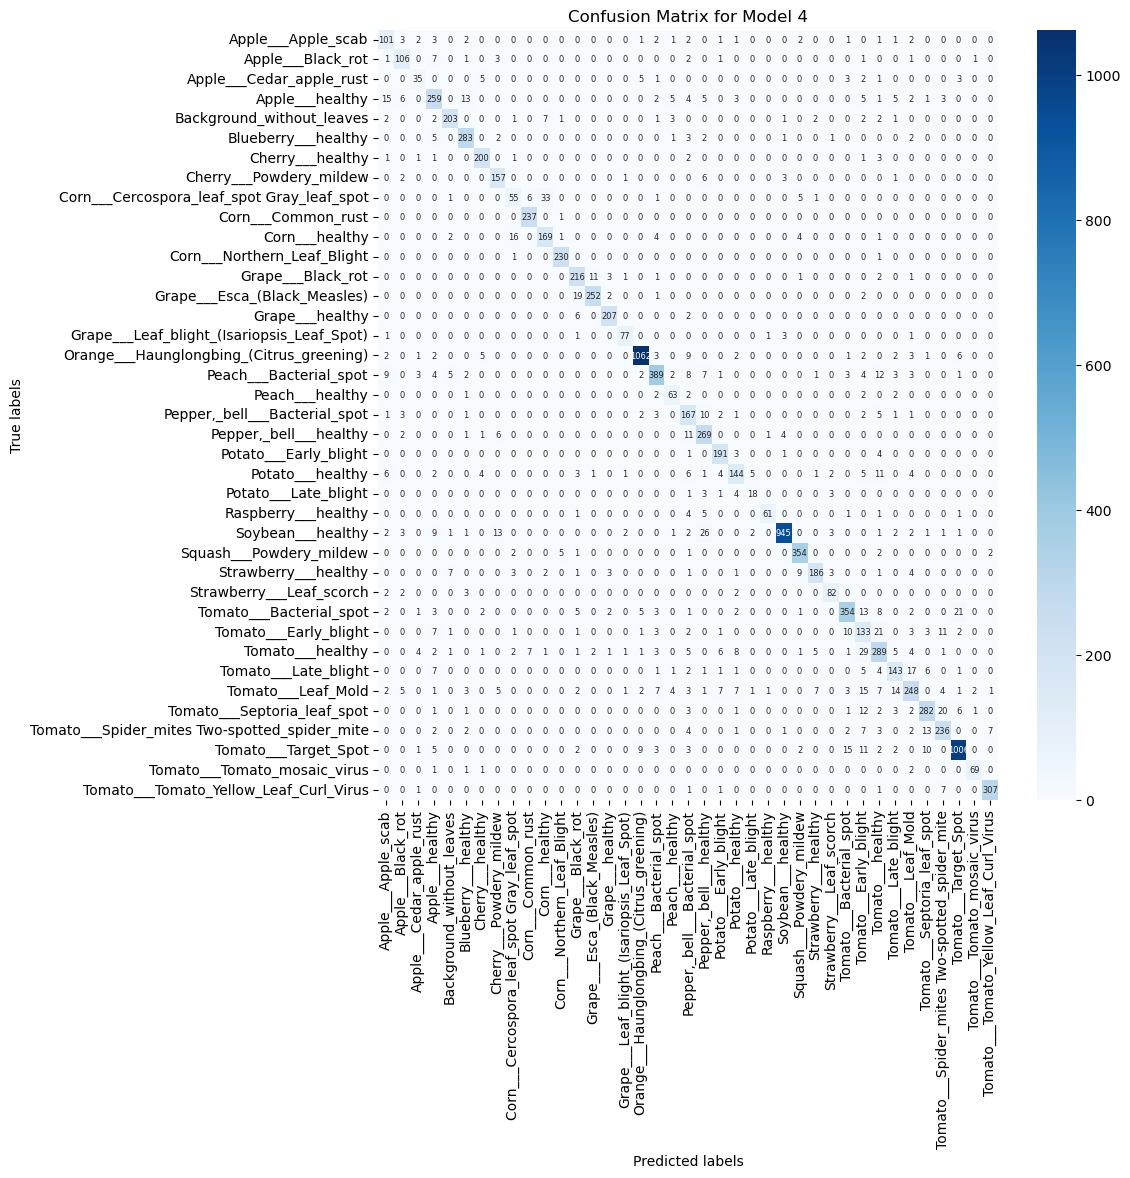

In [151]:
# plot confusion matrix for model 4
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix_4, annot=True, annot_kws={'size': 6}, fmt='g', cmap='Blues', 
            xticklabels=os.listdir(test_dir), 
            yticklabels=os.listdir(test_dir))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Model 4')
plt.show()

## 4.7. Summary

From the modeling and evaluation in this notebook, model built using balanced data with good amount of samples performs the best.

**About the boostrapping:**
* Using the boostrapping technique, the model performance was improved compared to individual models. (Model_3 and Model_4)
* Model trained with limited data showed poor perfromance even with the boostrapping technique. (Model_3)

**About data augmentation:**
* Data augmentation did not guanrantee better model. It made the model even worse in this notebook. (Model_1 VS Model_2) The reasone could be related to poor augmentated images which are not representative of original data.
* However, data augmentation plus the boostrapping technique increased the model performance in this notebook. (Model_4).

**About class imbalance:**
* The boostrapping technique helped mitigate the class imbalance issue. (comparing accuray in the classification report for class '2' between Model_1 and Model_4).
* However, the help from boostrapping is limited. From classification report, for class with small number of support, the accuracy was low.

## 4.8. Future Work

If time allows, the following aspects can be further investigated to improve the existing results.

**Modeling:**
* CNN model hyper parameter tuning, such as the optimization method, metric, epoch numbers, dropout percentage.

**Feature Engineering:**
* Boostrapping to draw more images from data without augmentation, such as to draw 500 images for each class.
* If improvement is observed for the step above, try drawing more images for each class.
* Boostrapping to draw more images from data with augmentation, say 1500 for each class to see if there is any improvements.

**Pre-processing:**
* After settling down on the model and feature engineering part, try using gray scale images as the input to reduce computational cost.

**Data Augmentation:**
* limit to one augmentation method to see if certain augmentation better improves model performance.

**Input Data:**
* Search online to collect more images for the classes with limited number of samples.